In [1]:
#Import libraries 
import qutip as qt
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from qutip.qip.operations import swap
import pickle
import json 
import os
from multiprocessing import Pool


In [2]:
#System variables

# w = 1e-1
# gamma = 1e-1

class OpenSYK():
  def __init__(self, w, gamma_w, w_g, N, gamma_beta, model):
    # Model
    self.Model= model
   
    # Central fermion strength 
    self.w= w
    self.w_g= w_g

    # Interaction strength
    self.g = (1/self.w_g)* self.w

    # Majorana fermions number
    self.N= N

    # Coupling function strength 
    self.gamma_w= gamma_w
    self.gamma= self.w*self.gamma_w
    self.gamma_beta = gamma_beta
    # Bath temperature
    self.beta = self.gamma*(1/self.gamma_beta)

    #number of fermions = [complex fermions + central fermion(model 1), complex fermions(model 2)]
    
    self.n1 = self.N//2+1
    self.n2 = self.N//2

    #model
   # self.model= model
  
  #Define fermion operators using the Jordan-Wigner transform (n or N//2)
  @property
  def fermion_operators(self):
    if self.Model==1:
      return [qt.tensor(*[qt.destroy(2) if i == j\
                  else (qt.sigmaz() if j < i\
                      else qt.identity(2))\
                          for j in range(self.n1)])\
                              for i in range(self.n1)]
    if self.Model==2:
      return [qt.tensor(*[qt.destroy(2) if i == j\
                  else (qt.sigmaz() if j < i\
                      else qt.identity(2))\
                          for j in range(self.n2)])\
                              for i in range(self.n2)]

  
  #Hamiltonian of the system SYK+central fermion
  @property
  def Hamiltonian1(self):
    N = self.N
    c_fermi = self.fermion_operators
    wg = np.zeros(self.n1)
    wg[0] = self.w/2 # isolated fermion energy
    wg[1:]= self.g   # interaction strength

    #random interaction matrix 
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    K = np.random.randn(self.N,self.N) 
    K = 0.5*(K - K.T)

    # K_ab eigenenergies
    lbd= np.linalg.eigvals(K)
    lbd=[np.imag(lbd)[x] for x in range(0,len(lbd),2)]

    #define M
    M=np.zeros((self.n1)**2)
    M= M.reshape(self.n1,self.n1)
    M[0]= wg
    for x in range(self.n2): 
      M[x+1][x+1] =lbd[x]/2
    M = M + M.T
    epsilon = np.linalg.eigvals(M)

    #coupling constants and quasifermions normalizations constants
    norms= np.sqrt([1+self.g**2*sum(1/(lbd[i]-epsilon[j])**2 for i in range(len(lbd))) for j in range(len(epsilon))])
    random_c = np.array([1+self.g*sum(1/(lbd[i]-epsilon[j]) for i in range(len(lbd))) for j in range(len(epsilon))])
    random_c = (random_c/norms)**2
    random_cps = [self.gamma*(1+np.tanh(0.5*self.beta*epsilon[i]))*random_c[i] for i in range(len(random_c))]
    random_cps_m =[self.gamma*(1-np.tanh(0.5*self.beta*epsilon[i]))*random_c[i] for i in range(len(random_c))]
    
    # diagonalized Hamiltonian
    H_d = sum([ epsilon[i]*(c_fermi[i].dag()*c_fermi[i]) for i in range(self.n2)]) 
    return  H_d, epsilon, lbd, random_cps,random_cps_m, norms, c_fermi




In [5]:
psi_0 =qt.tensor(*[qt.basis(2,1) for j in range(P["N"][-1]//2+1)])

psi_1 =qt.tensor(*[qt.basis(2,0) for j in range(P["N"][-1]//2+1)])

psi_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [3]:


def solve1(times,inputs):

  H, eps, lamb, coupl_c, quasi_norms, c_fermi = inputs 
  N = Model.N
    
  #jump operators
  J_op = [np.sqrt(coupl_c[i])*c_fermi[i] for i in range(N//2+1)]
  J_opd = [np.sqrt(coupl_cm[i])*c_fermi[i].dag() for i in range(N//2+1)]
  #central fermion anihilation operator
  d = [c_fermi[i]/quasi_norms[i] for i in range(N//2+1)]
  D = sum(d)
  D_op= D.dag()*D

  #collapse operators
  C_op= [J_op[i].dag()*J_op[i] for i in  range(N//2+1)]

  #initial state
  psi_0 =qt.tensor(*[qt.basis(2,1) for j in range(N//2+1)])
  

  #Lindbladian eigenvalues 
  Lindbladian = qt.liouvillian(H, C_op)
  eps_L =Lindbladian.eigenenergies()
  #evolve and calculate expectation values for each quasi-fermion,d 
  #out = qt.mesolve(H, psi_0, times, J_op, C_op)
  out_d = qt.mesolve(H, psi_0, times, J_op, D_op)
  rho= qt.mesolve(H, psi_0, times, J_op, [])
    
  return out_d, rho, eps, eps_L



In [198]:
# Parameters 

P = {"w": [1e-1,1,1e1],"gamma/w":[1,1e1,1e2], "w/g": np.array([5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2, 5e2]),\
     "N":[10,4,2], "gamma/beta" : np.array([1e-6, 1e-4, 1e-3,1e-2,1e-1, 1, 1e1,1e2,1e3]),\
     "AverageNumber":350}

len_i= len(P["w"])
len_j= len(P["gamma/w"])
len_k= len(P["w/g"])
len_l= len(P["gamma/beta"])
times =np.arange(0,80,1e-2)
# Generate an especific model

def create_Model(a_0,a_1,a_2,a_3,a_4):
  return OpenSYK(P["w"][a_0], P["gamma/w"][a_1], P["w/g"][a_2], P["N"][a_4], P["gamma/beta"][a_3], 1 )


create_Model(0,0,0,0,0)



{'w': [0.1, 1, 10.0],
 'gamma/w': [1, 10.0, 100.0],
 'w/g': array([5.e-02, 1.e-01, 5.e-01, 1.e+00, 5.e+00, 1.e+01, 5.e+01, 1.e+02,
        5.e+02]),
 'N': [10, 4, 2],
 'gamma/beta': array([1.e-06, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03]),
 'AverageNumber': 350}

In [543]:
import sys 
# Multiprocessing function 

def solve_batch(args):
  #np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  i,j,k,l = args
  #number of iterations
  iterations = P["AverageNumber"]
  data= { "counts_d":[], "purity":[], "entropy":[], "eigenvalues":[], "eigenvalues_L":[], "rhot":[]}
  try:
    end=10
    step= 1e-2
    times = np.arange(0,end,step)
    for m in range(iterations):     
      Model = create_Model(i,j,k,l,m)
    #generate random variables
      variables = (Model.Hamiltonian1)
    # physical quantities
      purity=[]
      entropy=[]
      eigenvalues=[]
      eigenvalues_L =[]
      N= P["N"]
      # Solve the master equation
    
      result_q, result_d, rho ,eig, eig_L = solve1(times, variables)
      counts_d = result_d.expect
      rhot = rho.states
      eigenvalues.append(eig)
      eigenvalues_L.append(eig_L)
        
      for n in range(len(rhot)):
        # purity
        purity.append((rhot[n]**2).tr())
        #entropy
        entropy.append(qt.entropy_vn(rhot[n]))
    
    #save data
      data["counts_d"].append(counts_d)
      data["eigenvalues"].append(eigenvalues)
      data["eigenvalues_L"].append(eigenvalues_L)
      data["purity"].append(purity)
      data["entropy"].append(entropy)
      data["rhot"].append(rhot)
    print('w=%.3f, gamma=%.3f, g=%.3f, beta=%.3f'%(Model.w, Model.gamma,\
                                                   Model.g, Model.beta)," process saved")
    #save data
    with open('DataBatchParallel/w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+\
        'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)+'.pickle','wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 
  
  except:
    print(i,j,k,l," process failed")




In [5]:

def solve2(times, coupl_c, coupl_cm, c_fermi, N, H, norms):

  #jump operators
  J_op = [np.sqrt(coupl_c[i])*c_fermi[i] for i in range(N//2+1)]
  J_opd=[np.sqrt(coupl_cm[i])*c_fermi[i].dag() for i in range(N//2+1)]
  J =[ J_op, J_opd]
  J= [ J[i][j] for i in range(len(J)) for j in range(2)]
  #central fermion anihilation operator
  d = [c_fermi[i]/norms[i] for i in range(N//2+1)]
  D = sum(d)
  D_op= D.dag()*D
  #collapse operators
#gain model
  C_op= [J_op[i].dag()*J_op[i] for i in  range(N//2+1)]
#loss-gain model
  C= [J[i].dag()*J[i] for i in range(len(J))] 

  #initial state
  psi_0 =qt.tensor(*[qt.basis(2,1) for j in range(N//2+1)])
  #psi_0 = qt.tensor(*[qt.basis(2,0) for j in range(P["N"][-1]//2+1)])
  #Lindbladian operator
  # gain
  Lindbladian_g = qt.liouvillian(H, C_op)
  eps_Lg =Lindbladian_g.eigenenergies()
  # loss-gain
  Lindbladian_lg = qt.liouvillian(H, C)
  eps_Llg =Lindbladian_lg.eigenenergies()
    
  #evolve and calculate expectation values for each quasi-fermion,d 
  
#   out= qt.mesolve(H, psi_0, times, J_op, C_op)
  out_d = qt.mesolve(H, psi_0, times, J, D_op)
  rho= qt.mesolve(H, psi_0, times, J, [])

 #out= qt.mesolve(H, psi_0, times, J_opd, C_op)
#   out_d = qt.mesolve(H, psi_0, times, J_opd, D_op)
#   rho= qt.mesolve(H, psi_0, times, J_opd, [])
  
  return out_d, rho, eps_Llg


In [47]:

def matrix_histogram_complex(M, xlabels, ylabels, title, size, limits=None, ax=None):
    """
    Draw a histogram for the amplitudes of matrix M, using the argument of each element
    for coloring the bars, with the given x and y labels and title.

    Parameters
    ----------
    M : Matrix of Qobj
        The matrix to visualize

    xlabels : list of strings
        list of x labels

    ylabels : list of strings
        list of y labels

    title : string
        title of the plot

    limits : list/array with two float numbers
        The z-axis limits [min, max] (optional)

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.
    
    Returns
    -------

        An matplotlib axes instance for the plot.

    Raises
    ------
    ValueError
        Input argument is not valid.

    """

#    if isinstance(M, Qobj):
        # extract matrix data from Qobj
#    M = M.full()

    n= np.size(M) 
    xpos,ypos= np.meshgrid(range(M.shape[0]),range(M.shape[1]))
    xpos=xpos.T.flatten()-0.5 
    ypos=ypos.T.flatten()-0.5 
    zpos = np.zeros(n) 
    dx = dy = 0.8 * np.ones(n) 
    Mvec = M.flatten()
    dz = abs(Mvec) 
    
    # make small numbers real, to avoid random colors
    idx, = np.where(abs(Mvec) < 0.001)
    Mvec[idx] = abs(Mvec[idx])

    if limits: # check that limits is a list type
        z_min = limits[0]
        z_max = limits[1]
    else:
        phase_min = -np.pi
        phase_max = np.pi
        
    phase_min = -np.pi
    phase_max = np.pi    
    norm= mpl.colors.Normalize(phase_min, phase_max) 

    # create a cyclic colormap
    cdict = {'blue': ((0.00, 0.0, 0.0),
                      (0.25, 0.0, 0.0),
                      (0.50, 1.0, 1.0),
                      (0.75, 1.0, 1.0),
                      (1.00, 0.0, 0.0)),
            'green': ((0.00, 0.0, 0.0),
                      (0.25, 1.0, 1.0),
                      (0.50, 0.0, 0.0),
                      (0.75, 1.0, 1.0),
                      (1.00, 0.0, 0.0)),
            'red':   ((0.00, 1.0, 1.0),
                      (0.25, 0.5, 0.5),
                      (0.50, 0.0, 0.0),
                      (0.75, 0.0, 0.0),
                      (1.00, 1.0, 1.0))}
    cmap = mpl.colors.LinearSegmentedColormap('phase_colormap', cdict, 256)

    colors = cmap(norm(np.angle(Mvec)))

    if ax == None:
        fig = plt.figure(figsize=size)
        ax = Axes3D(fig, azim=-35, elev=35)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
    plt.title(title, fontsize= 24)

    # x axis
    ax.axes.w_xaxis.set_major_locator(ticker.IndexLocator(1,-0.5))
    ax.set_xticklabels(xlabels) 
    ax.tick_params(axis='x', labelsize=1)

    # y axis
    ax.axes.w_yaxis.set_major_locator(ticker.IndexLocator(1,-0.5)) 
    ax.set_yticklabels(ylabels) 
    ax.tick_params(axis='y', labelsize=1)

    # z axis
    #ax.axes.w_zaxis.set_major_locator(ticker.IndexLocator(-1,-0.5))
    ax.set_zlim3d([z_min, z_max])
    ax.set_zlabel('abs',size=22)
    
    ax.tick_params(labelsize=15)
    # color axis
    cax, kw = mpl.colorbar.make_axes(ax, shrink=.41, pad=.11)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    cb.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cb.set_ticklabels((r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'))
    cb.set_label('arg',size=22)
    cb.ax.tick_params(labelsize=22) 


    return ax



In [97]:
# sampling 
i,j,m= 0,0,-1
#i,j =1,1

for k in range(len_k):
#for k in K:
  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    data= { "counts_d":[], "purity":[], "entropy":[], "eigenvalues":[], "eigenvalues_L":[],\
       "rho_crit":[],"rho_sampling":[] }
    
    N = Model.N
    for s in range (P["AverageNumber"]):
        
      purity=[]
      entropy=[]
      #random variables   
      H, eig, lamb, coupl_c, coupl_cm, quasi_norms, f =  Model.Hamiltonian1
        
      # time evolution for the system
      result_d, rho,  eig_L = solve2(times, coupl_c, coupl_cm, f, N, H, quasi_norms)
      #counts_q= result_q.expect
      counts_d= result_d.expect
      rhot = rho.states
     
      for n in range(len(rhot)):
          # purity
          purity.append((rhot[n]**2).tr())
          #entropy
          entropy.append(qt.entropy_vn(rhot[n]))
            
      purity = np.array(purity)
      entropy = np.array(entropy)      
      min_pT =  np.where(purity== min(purity))[0][0]
    
      #save data
      data["counts_d"].append(counts_d)
    
      data["eigenvalues"].append(eig)
      data["eigenvalues_L"].append(eig_L)
      data["purity"].append(purity)
      data["entropy"].append(entropy)
    
      #State tomography
      data["rho_crit"].append(rhot[min_pT])
      data["rho_sampling"].append(rhot[::10])
        
    print('N=%s, w=%.3f, gamma=%.3f, g=%.3f, beta=%.3f'%(Model.N, Model.w, Model.gamma,\
              Model.g, Model.beta)," process saved")
    name = 'DataBatchParallel/N_%s/w%.3f_w_g%.3f_'%(Model.N, Model.w, Model.w_g)+\
        'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'\
         %(Model.gamma_w, Model.gamma_beta)+'.pickle'
    # loss and gain included 
    name_lg = 'DataBatchParallel/N_%s/loss_gain/w%.3f_w_g%.3f_'%(Model.N, Model.w, Model.w_g)+\
        'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'\
         %(Model.gamma_w, Model.gamma_beta)+'.pickle'
    with open(name_lg,'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 






## EXPERIMENTS

In [207]:
i,j,k,l,m= 0,0,-1,3,1
Model = create_Model(i,j,k,l,m)
H, eig, lamb, coupl_c, coupl_cm,  quasi_norms, f =  Model.Hamiltonian1

#result_d, rho,  eig_L,  = solve2(times, coupl_c, coupl_cm, f, N, H, quasi_norms)
rhot = rho.states
J_op = [np.sqrt(coupl_c[i])*f[i] for i in range(N//2+1)]
J_opd=[ np.sqrt(coupl_cm[i])*f[i].dag() for i in range(N//2+1)]
J =[ J_op, J_opd]
J= [ J[i][j] for i in range(len(J)) for j in range(2)]
C= [J[i].dag()*J[i] for i in  range(N//2+1)]

Lindbladian = qt.liouvillian(H, C)
eps_L =Lindbladian.eigenenergies()
eps_L
Model.g,Model.beta

(0.0002, 10.0)

In [282]:
end= 2000
times = np.append(np.linspace(0,10,200),np.arange(10,end,1))
times.size
i,j,k,l,m= 0,0,-1,3,-1
Model = create_Model(i,j,k,l,m)
Model.beta
not 1000%100

True

In [283]:
i,j,k,l,m= 0,0,-1,3,-1
Model = create_Model(i,j,k,l,m)

data= { "counts_d":[], "purity":[], "entropy":[], "eigenvalues":[], "eigenvalues_L":[],\
   "rho_crit":[],"rho_sampling":[] }

N = Model.N
samples= 3000
end= 1000
times = np.append(np.linspace(0,10,100),np.arange(10,end,5))
for m in range (samples):
  if not m%100:
    print('omg, only %s samples'%(m))

  purity=[]
  entropy=[]
  #random variables   
  H, eig, lamb, coupl_c, coupl_cm,  quasi_norms, f =  Model.Hamiltonian1

  # time evolution for the system
  times = np.append(np.linspace(0,10,200),np.arange(10,end,1))
  result_d, rho,  eig_L = solve2(times, coupl_c, coupl_cm, f, N, H, quasi_norms)
  counts_d= result_d.expect
  rhot = rho.states

  for n in range(len(rhot)):
      # purity
      purity.append((rhot[n]**2).tr())
      #entropy
      entropy.append(qt.entropy_vn(rhot[n]))

  purity = np.array(purity)
  entropy = np.array(entropy)      
  min_pT =  np.where(purity== min(purity))[0][0]

  #save data
  data["counts_d"].append(counts_d)

  data["eigenvalues"].append(eig)
  data["eigenvalues_L"].append(eig_L)
  data["purity"].append(purity)
  data["entropy"].append(entropy)

  #State tomography
  data["rho_crit"].append(rhot[min_pT])
  data["rho_sampling"].append(rhot[::10])

print('w=%.3f, gamma=%.3f, g=%.4f, beta=%.3f, N=%s, samples= %s'%(Model.w, Model.gamma,\
          Model.g, Model.beta, Model.N, samples)," process saved")





omg, only 0 samples
omg, only 100 samples
omg, only 200 samples
omg, only 300 samples
omg, only 400 samples
omg, only 500 samples
omg, only 600 samples
omg, only 700 samples
omg, only 800 samples
omg, only 900 samples
omg, only 1000 samples
omg, only 1100 samples
omg, only 1200 samples
omg, only 1300 samples
omg, only 1400 samples
omg, only 1500 samples
omg, only 1600 samples
omg, only 1700 samples
omg, only 1800 samples
omg, only 1900 samples
omg, only 2000 samples
omg, only 2100 samples
omg, only 2200 samples
omg, only 2300 samples
omg, only 2400 samples
omg, only 2500 samples
omg, only 2600 samples
omg, only 2700 samples
omg, only 2800 samples
omg, only 2900 samples
w=0.100, gamma=0.100, g=0.0002, beta=10.000, N=2, samples= 3000  process saved


In [306]:

m=-1

g,h= 4,4
E = {'error_s':[], 'error_p':[]}
S= []
S_d=[]
Pty =[]
Pty_d=[]

eig =np.array(data["eigenvalues"])
entropy_max= np.log(2**(N//2+1))
purity_min = 1/2**(N//2+1)
entropy = np.array(data["entropy"])/entropy_max
purity =np.array(data["purity"])/purity_min
av_entropy= np.mean(entropy,axis=0)
av_eig=  np.mean(eig, axis=0)  
av_purity= np.mean(purity,axis=0)


S= S_infty(Model.beta,av_eig)/entropy_max
Pty=  P_infty(Model.beta,av_eig)/purity_min
S, av_entropy[-1],Pty, av_purity[-1]


(mpf('0.43717373301257495'),
 0.5472401541753709,
 mpf('2.4096928377513924'),
 2.163581361610141)

In [309]:
Pty
Py= [Pty]*len(times)

[mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.4096928377513924'),
 mpf('2.409692837751

Text(0.5, 1.0, 'Purity w=0.100, g=0.00020, N=2, beta=10.000000')

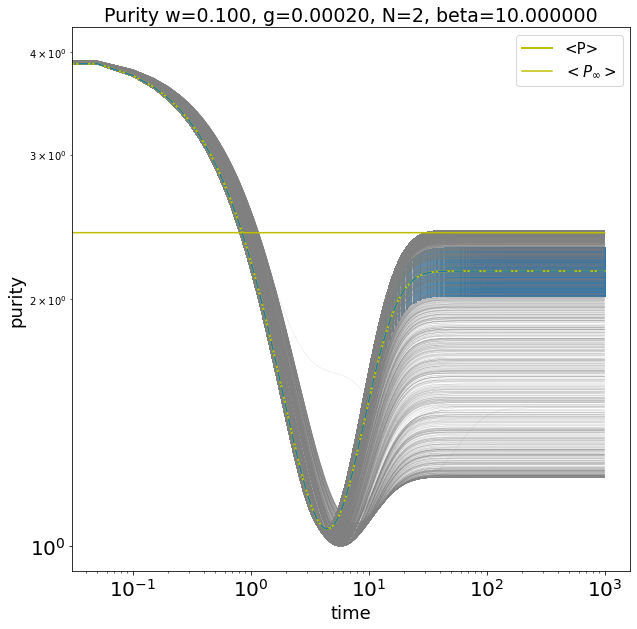

In [324]:

#Purity sampling 

fig = plt.figure(figsize=(10,10)) # Figureを作成
ax1 = fig.add_subplot(1,1,1) # Axesを作成

purity_min = 1/2**(N//2+1)
pu=np.array(data["purity"])/purity_min
av= np.mean(pu,axis=0),np.var(pu, axis=0)

for n in range(samples):
    ax1.plot(times,pu[n],linewidth=0.1, c='grey')
ax1.errorbar(times, av[0], av[1], linestyle='-.')
ax1.plot(times,av[0], c='y',linewidth= 2, label="<P>")
ax1.plot(times,Py,c='y', label=r"$<P_\infty>$")
ax1.tick_params(labelsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.ylabel('purity', fontsize=18)
plt.xlabel('time', fontsize=18)
title = "Purity "+ 'w=%.3f, g=%.5f,'%(Model.w, Model.g)+\
       ' N=%s,'%(N)+' beta=%.6f'%(Model.beta)

plt.legend(fontsize=15)
plt.title(title, fontsize= 19)

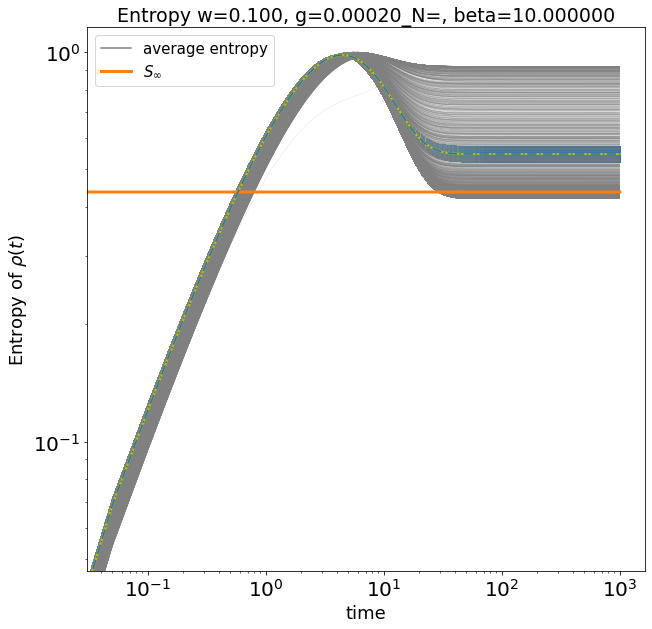

In [321]:
#Entropy sampling 

fig = plt.figure(figsize=(10,10))


entropy_max= np.log(2**(N//2+1))
entropy= data["entropy"]/entropy_max
pu=np.array(entropy)
av= np.mean(pu,axis=0),np.var(pu, axis=0)
S= [S_infty(Model.beta,av_eig)/entropy_max]*len(times)
for n in range(samples):
  plt.plot(times,pu[n],linewidth=0.1,c="grey")
plt.plot(times, av[0],label="average entropy", c="grey")
plt.errorbar(times,av[0],av[1], linestyle='-.')
plt.plot(times,av[0], c='y', linewidth= 2)
plt.plot(times, S, linewidth=3, label=r"$S_\infty$")
plt.ylabel("Entropy of $\\rho(t)$",fontsize=18)
plt.xlabel("time", fontsize=18)
title = "Entropy "+ 'w=%.3f, g=%.5f_'%(Model.w, Model.g)+\
        'N=%.s'%(N)+', beta=%.6f'\
         %(Model.beta)
plt.title(title, fontsize=19)
plt.legend(fontsize=15)
plt.tick_params(labelsize=20)
plt.xscale('log')
plt.yscale('log')

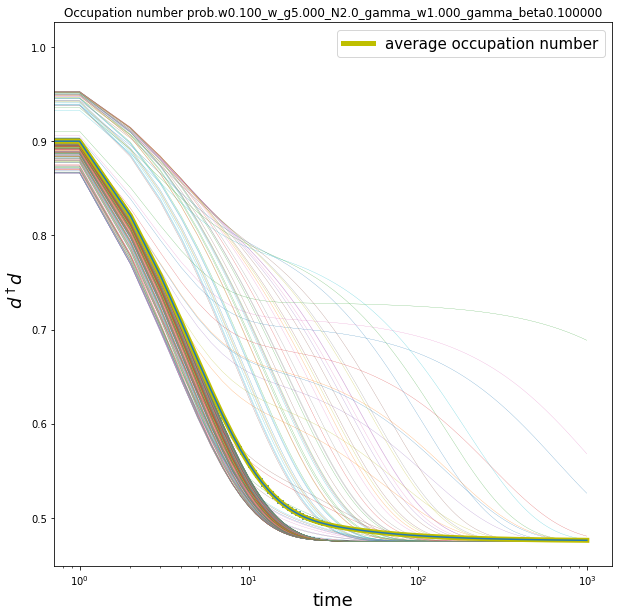

In [146]:
#Occupation number sampling 

fig = plt.figure(figsize=(10,10))
#Model = create_Model(i,j,k,l,m)
occ = np.array(data["counts_d"])
occ= occ.reshape(samples,len(times))
av = np.mean(occ,axis=0), np.var(occ, axis=0)


for n in range(samples):
  plt.plot(times,occ[n],linewidth=0.2)
plt.errorbar(times, av[0],av[1])
plt.plot(times,av[0],c='y', linewidth=5,label="average occupation number")

plt.ylabel("  $d^\dagger d$",fontsize=18)
plt.xlabel("time", fontsize=18)
plt.title("Occupation number prob."+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
          +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta))
plt.legend(fontsize=15)
plt.xscale('log')

Text(0.5, 1.0, 'Eigenvalue distribution of L w0.100_w_g5.000_N2.0_gamma_w1.000_gamma_beta0.100000')

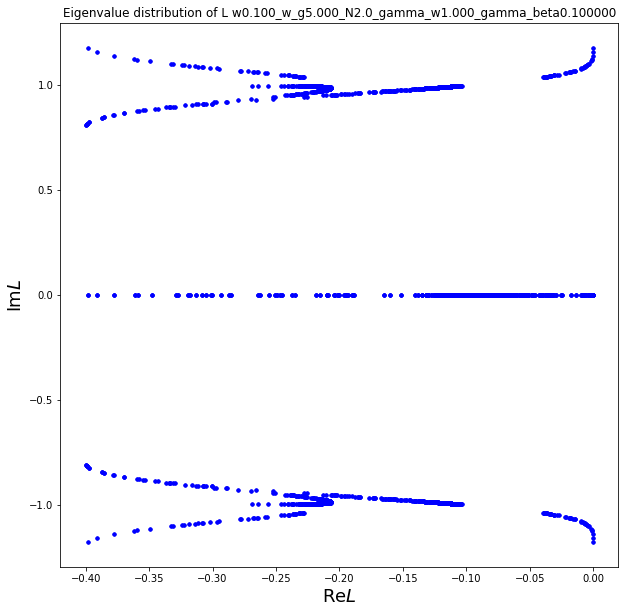

In [189]:
#L eigenvalues


fig = plt.figure(figsize=(10,10))
#Model = create_Model(i,j,k,l,m)
w = Model.w
eig =np.array(data["eigenvalues_L"])/w
#plt.scatter(np.real(eig[0]),np.imag(eig[0]))
Re_eig= np.real(eig)
Im_eig= np.imag(eig)


plt.scatter(Re_eig, Im_eig, c ="b",s=10)



plt.ylabel("Im"+"$L$",fontsize=18)
plt.xlabel("Re"+"$L$", fontsize=18)
plt.title("Eigenvalue distribution of L "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
          +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta))
#plt.legend()
# plt.savefig("ImagesBatchParallel/Eigenvalues_L/N_4/Eigenvalues_L "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
#             +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta))







## TIME EVOLUTION (Parallel)

In [ ]:


##################################################
#Calculate the time evolution of the system

#################################################

if __name__ == '__main__': 
  process=[]
  with Pool(8) as p:
    i,j=0,0
    for k in range(len_k):
    #for k in K:
      for l in range(len_l):
        process.append(p.apply_async(solve_batch,(i,j,k,l)) )
    process = np.array(process)
    #process= process.reshape(len_k, len_l)
    process= process.reshape(len(K), len_l)
    #for n in range(len_k):
    for n in K:
      for p in range(len_l):
        np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
        process[n][p].get()
    process[0].get()
    



In [94]:
N=4
def RM(N):
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    K = np.random.randn(N,N)
    K = K - K.T
    return K
test=5*[N]
a= qt.parallel_map(RM,test)




In [ ]:
# parallel computation 
x,y= np.meshgrid(np.arange(9),np.arange(9))
heble= np.array([y.reshape(-1),x.reshape(-1)])


def test(arg,I,J):
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    k,l = arg
    i,j= I,J
    args= i,j,k,l
    solve_batch(args)
  
qt.parallel_map(test,heble.T, task_args=(0,0,), num_cpus=8, progress_bar= True)




## Data collection

In [51]:
DATA=[]
i,j= 0,0
m= -1
for k in range(len_k):
  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name = 'DataBatchParallel/N_%s/gain/w%.3f_w_g%.3f_'%(Model.N, Model.w, Model.w_g)+'N%.1f_'%(P["N"][m])\
              +'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)
    name_lg = 'DataBatchParallel/N_%s/loss_gain/w%.3f_w_g%.3f_'%(Model.N, Model.w, Model.w_g)+\
        'N%.1f_'%(Model.N)+'gamma_w%.3f_gamma_beta%.6f'\
         %(Model.gamma_w, Model.gamma_beta)
    with open(name_lg+'.pickle','rb') as handle:
      DATA.append(pickle.load( handle))

DATA = np.array(DATA)




In [ ]:
# import os

# files_to_rename = [ 'w_g'+'%.3f_'%(Models[i].w_g)+'N%.1f_'%(parameters["N"][1])+'gamma_beta%.2f'%(Models[i].gamma_beta)+'.pickle'for i in range(cases)]
# renamed_files = ['w_g'+'%.3f_'%(Models2[i].w_g)+'N%.1f_'%(parameters["N"][2])+'gamma_beta%.2f'%(Models[0].gamma_beta)+'.pickle'for i in range(cases)]
# folder=r"/content/drive/MyDrive/Simulation_OpenSYK2/"
# # Iterate through the folder
# for i in range(cases):
#    # construct current name using file name and path
#    old_name = files_to_rename[i]
#   # construct full file path
#    new_name = renamed_files[i]
#   # Renaming the file
#    os.rename(old_name, new_name)

# # verify the result
# res = os.listdir(folder)
# print(res)



In [52]:

DATA = DATA.reshape(len_k,len_l)

DATA.shape




(9, 9)

In [ ]:
## ANALYTICAL SOLUTION FOR SS ENTROPY

In [52]:

## Use arbitrary float precision to avoid nan values
from mpmath import *

def S_infty(Beta, eps):
    e0, e1= eps
    #e0 = abs(e0)
    #e1 = abs(e1)
    e= e0+e1
    return  Beta*((e0*exp(-Beta*e0)+e1*exp(-Beta*e1)\
           +e*exp(-Beta*e) )/(1+exp(-Beta*e0)\
           +exp(-Beta*e1)+exp(-Beta*e)) )+log(1+exp(-Beta*e0)\
           +exp(-Beta*e1) +exp(-Beta*e))

def P_infty(Beta,eps):
    e0, e1= eps
    e= e0+e1
    L= 1+exp(-Beta*e0)+exp(-Beta*e1)\
        +exp(-Beta*e)
    return (1+exp(-2*Beta*e0)+exp(-2*Beta*e1)\
               +exp(-2*Beta*e))/L**2
   


In [93]:

m=-1

g,h= 4,4
E = {'error_s':[], 'error_p':[]}
S= []
S_d=[]
Pty =[]
Pty_d=[]

Model = create_Model(0,0,g,h,0)
eig =np.array(DATA[g][h]["eigenvalues"])
entropy = np.array(DATA[g][h]["entropy"])
av_entropy= (entropy).sum(axis=0)/50 
av_eig=  (eig.sum(axis=0))/(50)  
purity =np.array(DATA[g][h]["purity"])
av_purity= (purity.sum(axis=0))/50 

for f in range(len(eig)):
    S.append(S_infty(Model.beta, eig[f]))
    S_d.append(entropy[f][-1])
    Pty.append(P_infty(Model.beta,eig[f]))
    Pty_d.append(purity[f][-1])

S=np.array(S)
S_d = np.array(S_d)
Pty = np.array(Pty)
Pty_d = np.array(Pty_d)
Error_s, Error_p=np.abs(S_d-S), np.abs(Pty_d - Pty)
E['error_s'].append(Error_s)
E['error_p'].append(Error_p)
S_av=  S.sum(axis=0)/50
DATA[g][h].update(E)
Ess= np.abs(S_av-av_entropy[-1])




## Graphs of physical quantities

In [380]:
size =18

In [428]:
#Purity sampling 
i,j= 0,0
N = P["N"][m]

for k in range(len_k):
  for l in range(len_l):
    fig = plt.figure(figsize=(10,10))
    Model = create_Model(i,j,k,l,m)
    av_purity=  (np.array(DATA[k][l]["purity"]).sum(axis=0))/50 

    purity_min = [1/2**(N//2+1)]*len(times)
    for n in range(P["AverageNumber"]):
      plt.plot(times,DATA[k][l]["purity"][n],linewidth=0.2)
    plt.plot(times, av_purity,label="average purity")
    plt.plot(times,purity_min, label="min. purity")
    #plt.xscale('log')
    
    plt.ylabel("Purity of $\\rho(t)$",fontsize=size)
    plt.xlabel("time", fontsize=size)
    
    name_m = "ImagesBatchParallel/Purity/loss_gain/N_%s"%(N)+"/Purity "\
    +'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+'N%.1f_'%(N)\
    +'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    title = "Purity "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+\
    'N%.1f_'%(N)\
    +'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)
    
    plt.title(title, fontsize= size)
    plt.legend(fontsize=size)
    
    plt.savefig(name_m)
    plt.close(fig)

In [429]:
#Entropy sampling 
i,j= 0,0
N = P["N"][m]
for k in range(len_k):
  for l in range(len_l):
    fig = plt.figure(figsize=(10,10))
    Model = create_Model(i,j,k,l,m)
    av_entropy=  (np.array(DATA[k][l]["entropy"]).sum(axis=0))/50 
    entropy_max= [np.log(2**(N//2+1))]*len(times)

    
    for n in range(P["AverageNumber"]):
      plt.plot(times,DATA[k][l]["entropy"][n],linewidth=0.2)
    plt.plot(times, av_entropy,label="average entropy")
    plt.plot(times, entropy_max, label="max. entropy")
    #plt.xscale('log')
    plt.ylabel("Entropy of $\\rho(t)$",fontsize=size)
    plt.xlabel("time", fontsize=size)
    name_g= "ImagesBatchParallel/Entropy/N_%s"%(N)+\
    "/gain/Entropy "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    #loss_gain
    name_lg= "ImagesBatchParallel/Entropy/N_%s"%(N)+\
    "/loss_gain/Entropy "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    
    title = "Entropy "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)
    plt.title(title, fontsize= size)
    plt.legend(fontsize = size)
    
    plt.savefig(name_lg)
    plt.close(fig)

In [430]:
#Occupation number sampling 
i,j= 0,0
N = P["N"][m]
for k in range(len_k):
  for l in range(len_l):
    fig = plt.figure(figsize=(10,10))
    Model = create_Model(i,j,k,l,m)
    av_occ=  (np.array(DATA[k][l]["counts_d"]).sum(axis=0))/50 
    d_min = [min(av_occ[0])]*len(times)
    
    for n in range(P["AverageNumber"]):
      plt.plot(times,DATA[k][l]["counts_d"][n][0],linewidth=0.2)
    plt.plot(times, av_occ[0],label="average occupation number prob.")
    plt.plot(times, d_min, label="min. occupation prob. %.2f"%(d_min[0]))

    title= "Occupation number prob."+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
              +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)
    name_g= "ImagesBatchParallel/OccupationNumber/N_%s"%(N)\
    +"/gain/OccupationN "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    name_lg= "ImagesBatchParallel/OccupationNumber/N_%s"%(N)\
    +"/loss_gain/OccupationN "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    plt.ylabel("  $d^\dagger d$",fontsize=18)
    plt.xlabel("time", fontsize=18)
    plt.title(title, fontsize= size)
    plt.legend(fontsize = size)
    plt.savefig(name_lg)
    plt.close(fig)




In [ ]:
#H eigenvalues

i,j= 0,0
N = P["N"][m]
for k in range(len_k):
  for l in range(len_l):
    fig = plt.figure(figsize=(10,10))
    Model = create_Model(i,j,k,l,m)
    w = Model.w
    eig =np.array(DATA[k][l]["eigenvalues"])
    eig = np.sort(eig)/w
    av_eig=  (eig.sum(axis=0))/(50) 
    av_eig= av_eig.reshape(6)
    x= np.arange(1,len(av_eig)+1)
    
    for n in range(P["AverageNumber"]):
      plt.scatter(x,eig[n], c ="b",s=17)
    plt.scatter(x, av_eig,label="average eigenvalue ", c="r", s= 27 )
    

    plt.ylabel("  $\epsilon_i/\omega$",fontsize=18)
    plt.xlabel("i", fontsize=18)
    plt.title("Eigenvalue distribution of H "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
              +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta))
    plt.legend(fontsiz=size)
    plt.savefig("ImagesBatchParallel/Eigenvalues_H/EH_0_0/Eigenvalues_H "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta))
    plt.close(fig)





In [431]:
#L eigenvalues

i,j= 0,0

N = P["N"][m]
for k in range(len_k):
  for l in range(len_l):
    fig = plt.figure(figsize=(10,10))
    Model = create_Model(i,j,k,l,m)
    w = Model.w
    eig =np.array(DATA[k][l]["eigenvalues_L"])/w
    Re_eig= np.real(eig)
    Im_eig= np.imag(eig)
    
    plt.scatter(Re_eig, Im_eig, c ="b",s=10)
    
    plt.ylabel("Im"+"$L$",fontsize=size)
    plt.xlabel("Re"+"$L$", fontsize=size)
    
    title = "Eigenvalue distribution of L "+\
    'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)
    name_g= "ImagesBatchParallel/Eigenvalues_L/N_%s"%(N)+"/gain/Eigenvalues_L "\
    +'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    name_lg= "ImagesBatchParallel/Eigenvalues_L/N_%s"%(N)+"/loss_gain/Eigenvalues_L "\
    +'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    plt.title( title, fontsize = size )
    plt.savefig(name_lg)
    plt.close(fig)





In [391]:

m= 0
# multiple animation 
N = P["N"][m]

for k in range(len_k):

  for l in range(len_l):

    Model = create_Model(i,j,k,l,m)

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,12))

    # Purity
    purity_min = [1/2**(N//2+1)]*len(times)
    av_purity=  (np.array(DATA[k][l]["purity"]).sum(axis=0))/(50*purity_min[0]) 
    for n in range(P["AverageNumber"]):
      ax1.plot(times,(DATA[k][l]["purity"][n])/purity_min[0],linewidth=0.2)
    ax1.plot(times, av_purity,label="average purity")
    #ax1.plot(times,purity_min, label="min. purity")

    ax1.set_xlabel('time', fontsize=18)
    ax1.set_ylabel(r'$P(t)/P_{min}$', fontsize=15)
    ax1.set_title('Purity',fontsize=21)
    ax1.legend(fontsize= size)

    #Von Neumann entropy
    entropy_max= [np.log(2**(N//2+1))]*len(times)
    av_entropy=  (np.array(DATA[k][l]["entropy"]).sum(axis=0))/(50*entropy_max[0]) 
    
    for q in range(P["AverageNumber"]):
      ax2.plot(times,(DATA[k][l]["entropy"][q])/entropy_max[0],linewidth=0.2)
    ax2.plot(times, av_entropy,label="average entropy")
    #ax2.plot(times, entropy_max, label="max. entropy")

    ax2.set_ylabel("$S(t)/S_{max}$",fontsize=18)
    ax2.set_xlabel("time", fontsize=18)
    ax2.set_title("Von Neumann entropy ",fontsize=21)
    ax2.legend(fontsize= size)
   

    #Entropy of the system
    av_occ=  (np.array(DATA[k][l]["counts_d"]).sum(axis=0))/50 
    d_min = [min(av_occ[0])]*len(times)
    
    for r in range(P["AverageNumber"]):
      ax3.plot(times,DATA[k][l]["counts_d"][r][0],linewidth=0.2)
    ax3.plot(times, av_occ[0],label="average number")
    ax3.plot(times, d_min, label="min. %.2f"%(d_min[0]))

    ax3.set_ylabel("  $d^\dagger d$",fontsize=18)
    ax3.set_xlabel("time", fontsize=18)
    ax3.set_title("Occupation number prob.",fontsize=21)
    ax3.legend(fontsize = size)
    

    #Eigen values of the Liouvillian superoperator
    w = Model.w
    eig =np.array(DATA[k][l]["eigenvalues_L"])/w
    Re_eig= np.real(eig)
    Im_eig= np.imag(eig)
    
    ax4.scatter(Re_eig, Im_eig, c ="b",s=10)
    
    

    ax4.set_ylabel("Im"+r"$\frac{L}{\omega}$" ,fontsize=18)
    ax4.set_xlabel("Re"+r"$\frac{L}{\omega}$" , fontsize=18)
    ax4.set_title("Eigenvalue distribution of L ", fontsize=21)
  
    title = 'Quantities '+r'$\omega=%.3f$, '%(Model.w)+r'$\frac{\omega}{g}=$'+'%.3f, '%(Model.w_g)\
                +'N=%.1f, '%(N)+r'$\frac{J}{\omega}=$'+'%.3f, '%(Model.gamma_w)+ \
     r'$\frac{J}{\beta}=$'+'%.6f'%(Model.gamma_beta)
    
    name_g = 'ImagesBatchParallel/Quantities/N_%s/'%(N)\
                +'gain/Quantities w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    
    name_lg = 'ImagesBatchParallel/Quantities/N_%s/'%(N)\
                +'loss_gain/Quantities w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    fig.suptitle(title, fontsize=23)
    plt.savefig(name_lg)
    plt.close(fig)
    
    
    


In [11]:
def tomography(args,k,l):
        i,j,m = args
        size = (19,19)
        Model = create_Model(i,j,k,l,m)
        N = Model.N
         #data 
        av_RHOSP= (np.array(DATA[k][l]["rho_sampling"])).sum(axis=0)/50
        #print(av_RHOSP.shape)
        for n in range(len(av_RHOSP)):
            RHOSPvec = av_RHOSP[n].flatten()
            max_abs = max(abs(RHOSPvec))
            title='w%.3f_w_g%.3f_'%(Model.w, Model.w_g)+\
            'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f'%(Model.gamma_w, Model.gamma_beta)\
            +"t=%.2f"%(times2[n])
            name_m = 'ImagesBatchParallel/StateTomography/N_%s/'%(N)\
            +'SP w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
            +'N%.1f_'%(N)+\
            'gamma_w%.3f_gamma_beta%.6f_t_%.2f.jpg'%(Model.gamma_w, Model.gamma_beta,times2[n])
            ax1 = matrix_histogram_complex(av_RHOSP[n], title= "rho(t) "+title,\
                    xlabels=[], ylabels=[], size= size,limits=[0,max_abs])
            
            
            plt.savefig(name_m)
            plt.close()
        
        RHOSPvec = []
        av_RHOSP=[]
        print(i,j,k,l," process saved")

x,y= np.meshgrid(np.arange(9),8)
len_x = len(np.arange(9))
len_y = len(np.arange(0,9,3))
heble= np.array([y.reshape(-1),x.reshape(-1)])

args= 0,0,1
for k,l in heble.T:
    tomography(args,k,l)
    

<ipython-input-8-34d62b30b506>:88: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-35, elev=35)


0 0 8 0  process saved
0 0 8 1  process saved
0 0 8 2  process saved
0 0 8 3  process saved
0 0 8 4  process saved
0 0 8 5  process saved
0 0 8 6  process saved
0 0 8 7  process saved
0 0 8 8  process saved


<ipython-input-367-7e82cd285b49>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X, fontsize=20)


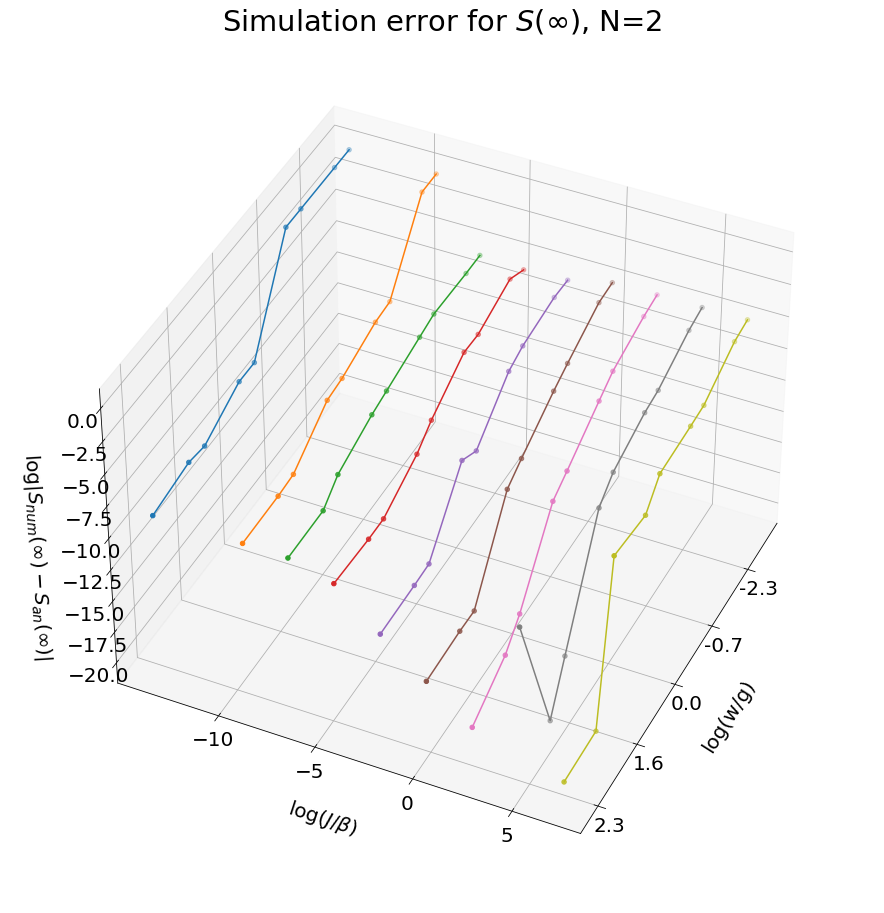

In [367]:
#deviation from analytical result (entropy)
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import mpl_toolkits.mplot3d

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(16,16))

K= np.arange(len_k)
L = np.arange(len_l)
X=np.log(P['w/g'])
Y= np.log(P['gamma/beta'])
X= np.round(X, decimals=1)
Y= np.round(Y, decimals=1)
Z = np.array([[np.array(DATA[k][l]['error_s']).sum(axis=0)/50 for k in K ]for l in L])

Z=Z.sum(axis=2)/50
Where_Nan = np.isnan(Z)
Z[Where_Nan]= 1

for d in range(len_k):
    ax.plot(X,np.ones(len_k)*Y[d],np.log(Z[:][d]) )
    ax.scatter(X,np.ones(len_k)*Y[d],np.log(Z[:][d]) )

    #ax.set_zscale('log')

ax.set_zlabel(r'$\log|S_{num}(\infty)-S_{an}(\infty)|$',fontsize=20, labelpad= 25.2 )
ax.set_xlabel('log(w/g)',fontsize=20, labelpad= 25.2 )
ax.set_ylabel(r'$\log(J/\beta)$', fontsize=20, labelpad= 25.2 )
ax.view_init(azim=25, elev=40)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
ax.set_xticklabels(X, fontsize=20)
ax.dist = 11
ax.set_title("Simulation error for"+r" $S(\infty)$,"+" N=%.f"%(Model.N), fontsize=29)
#ax.set_yticklabels(Y, fontsize=20)
name = 'ImagesBatchParallel/S_infty.jpg'
plt.savefig(name)

<ipython-input-474-8cd6891a2d80>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X, fontsize=20)


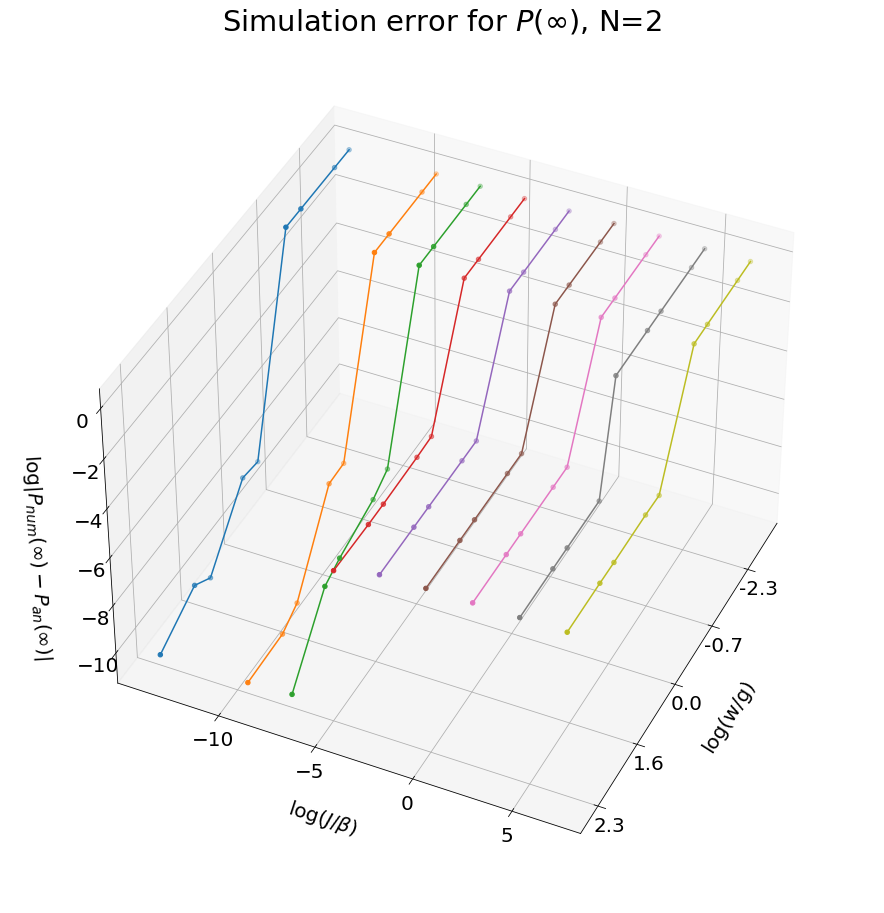

In [474]:
#deviation from analytical result (purity)
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import mpl_toolkits.mplot3d
N= P['N'][m]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(16,16))

K= np.arange(len_k)
L = np.arange(len_l)
X=np.log(P['w/g'])
Y= np.log(P['gamma/beta'])
X= np.round(X, decimals=1)
Y= np.round(Y, decimals=1)
Z = np.array([[np.array(DATA[k][l]['error_p']).sum(axis=0)/50 for k in K ]for l in L])

Z=Z.sum(axis=2)/50
Where_Nan = np.isnan(Z)
Z[Where_Nan]= 1

for d in range(len_k):
    ax.plot(X,np.ones(len_k)*Y[d],np.log(Z[:][d]) )
    ax.scatter(X,np.ones(len_k)*Y[d],np.log(Z[:][d]) )


ax.set_zlabel(r'$\log|P_{num}(\infty)-P_{an}(\infty)|$',fontsize=20, labelpad= 25.2 )
ax.set_xlabel('log(w/g)',fontsize=20, labelpad= 25.2 )
ax.set_ylabel(r'$\log(J/\beta)$', fontsize=20, labelpad= 25.2 )
ax.view_init(azim=25, elev=40)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
ax.set_xticklabels(X, fontsize=20)
ax.dist = 11

ax.set_title("Simulation error for"+r" $P(\infty)$,"+" N=%.f"%(N), fontsize=29)
#ax.set_yticklabels(Y, fontsize=20)
name = 'ImagesBatchParallel/P_infty.jpg'
plt.savefig(name)

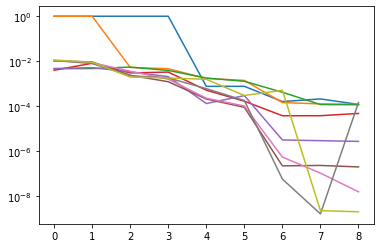

In [217]:

for l in L:
    plt.plot(K,Z[:][l])


plt.yscale('log')

## ANIMATIONS

In [433]:
#Animations for the physical quantities

from numpy.lib.function_base import kaiser
from PIL import Image

In [24]:
# Purity 

i,j,m =0,0,1
N = P["N"][m]
Images= []
for k in range(len_k):
  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name_m= "ImagesBatchParallel/Purity/N_%s"%(N)+\
    "/Purity "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name_m))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta= Images.T

#Purity

for k in range(len_k):
    
    Model = create_Model(i,j,k,l,m)
    
    name_w= 'Animations/Ani_Purity/N_%s'%(N)+\
    '/fixed_w/AniPurity '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    name_g = 'Animations/Ani_Purity/N_%s'%(N)+\
    '/fixed_g/AniPurity '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    Images[k][0].save(name_w,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
    Imagesbeta[k][0].save(name_g,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    


<ipython-input-24-bbbdee4800a0>:15: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Images = np.array(Images)
<ipython-input-24-bbbdee4800a0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images = np.array(Images)


In [31]:
#Entropy

i,j,m= 0,0,1
Images= []
N = P["N"][m]
for k in range(len_k):
  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name= "ImagesBatchParallel/Entropy/N_%s"%(N) \
    +"/Entropy "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta= Images.T
#Entropy


for k in range(len_k):
    
    Model = create_Model(i,j,k,l,m)
    
    name_w = 'Animations/Ani_Entropy/N_%s'%(N)+\
    '/fixed_w/AniEntropy '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    name_g = 'Animations/Ani_Entropy/N_%s'%(N)+\
    '/fixed_g/AniEntropy '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    Images[k][0].save(name_w,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
    Imagesbeta[k][0].save(name_g,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    



<ipython-input-31-d2a805d71430>:16: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Images = np.array(Images)
<ipython-input-31-d2a805d71430>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images = np.array(Images)


In [33]:
#Occupation number

i,j= 0,0
Images= []

for k in range(len_k):
  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name= "ImagesBatchParallel/OccupationNumber/N_%s"%(N)+\
    "/OccupationN "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta= Images.T

#Occupation Number


for k in range(len_k):
    
    Model = create_Model(i,j,k,l,m)
    
    name_w = 'Animations/Ani_OccupationNumber/N_%s'%(N)+\
    '/fixed_w/AniOccupationN '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    name_g = 'Animations/Ani_OccupationNumber/N_%s'%(N)+\
    '/fixed_g/AniOccupationN '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    Images[k][0].save(name_w,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)

    Imagesbeta[k][0].save(name_g,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    



    
   

<ipython-input-33-e634131ae175>:15: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Images = np.array(Images)
<ipython-input-33-e634131ae175>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images = np.array(Images)


In [34]:
# Lindbladian eigenvalues

i,j= 0,0
Images= []
for k in range(len_k):

  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name= "ImagesBatchParallel/Eigenvalues_L/N_%s"%(N)+\
    "/Eigenvalues_L "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta= Images.T




for k in range(len_k):
    
    Model = create_Model(i,j,k,l,m)
    
    name_w = 'Animations/Ani_Eigenvalues_L/N_%s'%(N)+\
    '/fixed_w/AniEL '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    name_g = 'Animations/Ani_Eigenvalues_L/N_%s'%(N)+\
    '/fixed_g/AniEL '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    Images[k][0].save(name_w,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
    Imagesbeta[k][0].save(name_g,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    



    
   
    
    

<ipython-input-34-daba4066dfeb>:15: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Images = np.array(Images)
<ipython-input-34-daba4066dfeb>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images = np.array(Images)


In [ ]:
# Hamiltonian eigenvalues
i,j= 0,0
Images= []
for k in range(len_k):

  for l in range(len_l):
    Model = create_Model(i,j,k,l)
    name= "ImagesBatchParallel/Eigenvalues_H/EH_0_0/Eigenvalues_H "+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(P["N"])+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)




for k in range(len_k):
    Model = create_Model(i,j,k,0)
    Images[k][0].save('Animations/Ani_Eigenvalues_H/AniEH_0_0/AniEigenvalues_H '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(P["N"])+'gamma_w%.3f.gif'%(Model.gamma_w),\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
  
 




In [439]:
#multiple graphs

i,j= 0,0
Images= []
for k in range(len_k):

  for l in range(len_l):
    Model = create_Model(i,j,k,l,m)
    name_m = 'ImagesBatchParallel/Quantities/N_%s/loss_gain/'%(N)\
    +'Quantities w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name_m))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta = Images.T




for k in range(len_k):
    Model = create_Model(i,j,k,l,m)
    Model_g = create_Model(i,j,k,k,m)
    name_w_LG = 'Animations/Ani_Quantities/N_%s'%(N)+\
    '/loss_gain/fixed_w/AniQ '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    name_g_LG = 'Animations/Ani_Quantities/N_%s'%(N)+\
    '/loss_gain/fixed_g/AniQ '+'w%.3f_'%(Model_g.w)\
    +'N%.1f_'%(N)+'beta%.5f.gif'%(Model_g.beta)
    
    Images[k][0].save(name_w_LG,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
    Imagesbeta[k][0].save(name_g_LG,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    

<ipython-input-439-1b977a4b6b3c>:15: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Images = np.array(Images)
<ipython-input-439-1b977a4b6b3c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Images = np.array(Images)


In [48]:
# #State tomography sampling

# i,j= 0,0
# Images= []
# K = [0,4,-1]
# L = [0,4,-1]
# for k in K:
#   for l in L:
#     Model = create_Model(i,j,k,l,m)
#     N = Model.N
#     for n in range(len(times2)):
#         name= 'ImagesBatchParallel/StateTomography/N_%s/'%(N)\
#             +'SP w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
#             +'N%.1f_'%(N)+\
#             'gamma_w%.3f_gamma_beta%.6f_t_%.2f.jpg'%(Model.gamma_w, Model.gamma_beta,times2[n])
#         Images.append(Image.open(name))


# Images = np.array(Images)
Images = Images.reshape(len(K), len(L), len(times2))
#Imagesbeta= Images.T
#Imagesbeta.shape

for k in range(len(K)):
  for l in range(len(L)):
    
    Model = create_Model(i,j,K[k],L[l],m)
    
    name_w = 'Animations/Ani_StateTomography/N_%s'%(N)\
    +'/fixed_w/Ani_RHOSP '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%6f.gif'%(Model.gamma_w, Model.gamma_beta)
   # name_g = 'Animations/Ani_StateTomography/Ani_RHOSP/SP_0_0/fixed_g/Ani_RHOSP '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    #+'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.gif'%(Model.gamma_w, Model.gamma_beta)
    
    
    Images[k][l][0].save(name_w,\
    save_all=True, append_images= Images[k][l][1:], optimize=False, duration= 1090, loop=0)
    #Imagesbeta[0][l][k].save(name_g,\
                #      save_all=True, append_images= Imagesbeta[1:][l][k],  optimize=False, duration= 1090, loop=0)
  
 




    
   
    
    

In [ ]:
i,j= 0,0
Images= []
for k in range(len_k):
  for l in range(len_l):
    Model = create_Model(i,j,k,l)
    name= 'ImagesBatchParallel/StateTomography/'+'RHOPT/PT_0_0/ PT_w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
                +'N%.1f_'%(N)+'gamma_w%.3f_gamma_beta%.6f.jpg'%(Model.gamma_w, Model.gamma_beta)
    Images.append(Image.open(name))


Images = np.array(Images)
Images = Images.reshape(len_k, len_l)
Imagesbeta= Images.T



for k in range(len_k):
    
    Model = create_Model(i,j,k,0)
    
    name_w = 'Animations/Ani_StateTomography/Ani_RHOPT/PT_0_0/fixed_w/Ani_RHOPT '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(P["N"])+'gamma_w%.3f.gif'%(Model.gamma_w)
    name_g = 'Animations/Ani_StateTomography/Ani_RHOPT/PT_0_0/fixed_g/Ani_RHOPT '+'w%.3f_w_g%.3f_'%(Model.w, Model.w_g)\
    +'N%.1f_'%(P["N"])+'gamma_w%.3f.gif'%(Model.gamma_w)
    
    Images[k][0].save(name_w,\
                      save_all=True, append_images= Images[k][1:],  optimize=False, duration= 1090, loop=0)
    Imagesbeta[k][0].save(name_g,\
                      save_all=True, append_images= Imagesbeta[k][1:],  optimize=False, duration= 1090, loop=0)
  
 
    

## Analytical calculations(master equation diagonalization)

In [21]:
from sympy import *

x,a,b,c,d,f,g,t = symbols ('x, a, b, c, d, f, g,t')



In [204]:
M= Matrix([[-(c+d), a, b, 0], \
          [c, -(a+d), 0, b],\
          [d, 0, -(c+b), a],\
          [0, d, c, -(a+b) ]]) 

lam = symbols('lambda')
cp = det(M - lam * eye(4))
cp_P= Poly(cp,lam)
eigval = solve(cp_P,lam)
EIG = M.eigenvects()


P,D = M.diagonalize()
Pm=P**-1
P*exp(D)*Pm

Matrix([
[ c*d/(a*b + a*d + b*c + c*d),  c*d/(a*b + a*d + b*c + c*d),  c*d/(a*b + a*d + b*c + c*d), c*d/(a*b + a*d + b*c + c*d)],
[-c*d/(a*b + a*d + b*c + c*d),  a*d/(a*b + a*d + b*c + c*d), -c*d/(a*b + a*d + b*c + c*d), a*d/(a*b + a*d + b*c + c*d)],
[-c*d/(a*b + a*d + b*c + c*d), -c*d/(a*b + a*d + b*c + c*d),  b*c/(a*b + a*d + b*c + c*d), b*c/(a*b + a*d + b*c + c*d)],
[ c*d/(a*b + a*d + b*c + c*d), -a*d/(a*b + a*d + b*c + c*d), -b*c/(a*b + a*d + b*c + c*d), a*b/(a*b + a*d + b*c + c*d)]])

In [234]:
N= Matrix([ [0, a, b, 0], \
            [0, -a, 0, b],\
            [0, 0, -b, a],\
            [0, 0, 0, -(a+b) ] ]) 

lam = symbols('lambda')
cp = det(N - lam*eye(4))
cp_P= Poly(cp,lam)
eigval = solve(cp_P,lam)
EIG = N.eigenvects()
PN,DN = N.diagonalize()
PNm=PN**-1
PNm
PN*exp(DN)*PNm


Matrix([
[1, 1 - exp(-a), 1 - exp(-b), exp(-a - b) + 1 - exp(-b) - exp(-a)],
[0,     exp(-a),           0,              -exp(-a - b) + exp(-a)],
[0,           0,     exp(-b),              -exp(-a - b) + exp(-b)],
[0,           0,           0,                         exp(-a - b)]])

In [212]:
L= Matrix([[-(a+b), a, b, 0], \
          [a, -(a+b), 0, b],\
          [b, 0, -(a+b), a],\
          [0, b, a, -(a+b) ]]) 

lam = symbols('lambda')
cp = det(L - lam * eye(4))
cp_P= Poly(cp,lam)
eigval = solve(cp_P,lam)
EIG = L.eigenvects()


PL,DL = L.diagonalize()
PLm=PL**-1
PL*exp(DL)*PLm
L


Matrix([
[-a - b,      a,      b,      0],
[     a, -a - b,      0,      b],
[     b,      0, -a - b,      a],
[     0,      b,      a, -a - b]])

In [22]:
M = Matrix([[x-d,c],\
           [d,x-c]])
v = Matrix([[f],[g]])
lam = symbols('lambda')
cp = det(M - lam * eye(2))
cp_P= Poly(cp,lam)
eigval = solve(cp_P,lam)
EIG = M.eigenvects()
PL,DL = M.diagonalize()
PLm=PL**-1
PL*exp(DL*t)*PLm*v


Matrix([
[f*(-c*exp(t*x)/(d*(-c/d - 1)) - exp(t*(-c - d + x))/(-c/d - 1)) + g*(c*exp(t*(-c - d + x))/(-c - d) - c*exp(t*x)/(d*(-c/d - 1)))],
[           f*(-exp(t*x)/(-c/d - 1) + exp(t*(-c - d + x))/(-c/d - 1)) + g*(-c*exp(t*(-c - d + x))/(-c - d) - exp(t*x)/(-c/d - 1))]])